In [1]:
import numpy as np, pandas as pd
from glob import glob
from astropy.table import Table
from matplotlib import pyplot as plt, colors as colors, colorbar as cbar

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

%matplotlib inline

/Users/carina/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/carina/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/carina/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/carina/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/carina/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may

# Reading in Data

In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
timescale_df = pd.read_csv('timescales.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
len(joined)

6484

In [3]:
joined.columns

Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
       'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
       'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
       'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
       'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
       'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
       'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
       'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'Unnamed: 0_x',
       'CommonName_y', 'Class', 'CoarseClass', 'IsBinary', 'Unnamed: 0_y',
       'WISE_Designation_x', 'N_obs', 'W1chi2', 'W1chi2red', 'W1_MAD',
       'W1_EWM', 'W2chi2', 'W2chi2red', 'W2_MAD', 'W2_EWM', 'W1-W2chi2',
       'W1-W2chi2red', 'W1-W2_MAD', 'W1-W2_EWM', 'Unnamed: 0',
       'WISE_Designation_y', 'N_visits', 'W1_Nzeroes', 'W1_meanDt', 'W1_stdDt',
       'W2_Nzeroes', 'W2_meanDt', 'W2_stdDt', 

# Classification algorithms are great at drawing horizontal/vertical lines in feature-space, so we're going to want to make things as easy as possible here, and use PCA to pull out features of maximum variance. This will also let us construct colors that span pretty large wavelength baselines through linear combinations.

In [4]:
#Let's throw out classes that we don't care about/aren't specific enough, plus binaries
training_indices = np.array([c not in np.array(['Misc. Variable','OBA','Unknown/Candidate']) 
 for c in joined['Class'].values]) & np.array([i == 0 for i in joined['IsBinary'].values]) & (joined['J-H'] < 2)
training_data = joined[training_indices].fillna(0).reset_index()

#Our features will be color and G/W1 magnitude.
X = training_data[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1']]
scaler=StandardScaler()
X_scale = scaler.fit_transform(X)
y = training_data['Class']

len(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scale, y, test_size=0.3, random_state=np.random.randint(1))

test_rf = RandomForestClassifier(n_jobs=-1,max_depth=10,n_estimators=80,max_features='log2')
#the best parameters for an early fit
classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBAe','OB[e]','WR','LBV','YSG',
                   'RSG','C/S/Giant']

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
def my_scorer(estimator, X, y=None):
    try:
        X = X.values
        X_rtrain = estimator.fit_transform(X_train)
        x_rtest = estimator.transform(X_test)
        test_rf.fit(X_rtrain,y_train)
        y_pred = test_rf.predict(X_rtest)
        cm = confusion_matrix(y_test,y_pred,labels=classes)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        np.nan_to_num(cm,copy=False)
        return np.diag(cm).sum()
    except:
        return -np.inf

loggamma_def = np.log10(1.0/len(X.columns))

param_grid = [{"kernel": ["rbf"], "gamma":np.array([0.01,0.1])}, 
              {"kernel": ["sigmoid"], "coef0": np.linspace(0,5,11), "gamma":np.array([0.01,0.1,1,10])},
              {"kernel": ["poly"], "coef0": np.linspace(5,10,11), "degree": [2,3,4], "gamma":np.array([0.01,0.1,1,10])}]

kpca=KernelPCA(n_components=9, fit_inverse_transform=True, n_jobs=-1) 
grid = GridSearchCV(kpca, param_grid, cv=3, scoring=my_scorer,n_jobs=-1)
grid.fit(X_scale)

kpca = grid.best_estimator_
print(grid.best_params_)

LinAlgError: Matrix is singular.

In [6]:
X_r = pd.DataFrame(data=kpca.fit_transform(X),columns=[f'C_{i}' for i in range(kpca.n_components)])

In [7]:
X_r

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8
0,-0.586486,-0.457321,0.111199,0.261115,-0.052212,0.139083,0.004765,0.223411,-0.151390
1,-0.558377,-0.482897,0.200747,0.270686,-0.097797,0.189469,0.118818,0.226038,-0.143909
2,-0.531108,-0.456247,0.273693,0.270524,-0.114166,0.181220,0.180326,0.230258,-0.205293
3,-0.584954,-0.470505,0.161771,0.257149,-0.078826,0.155819,0.067656,0.208416,-0.153370
4,-0.592394,-0.424669,0.276115,0.211040,-0.132287,0.100887,0.175587,0.133289,-0.212184
...,...,...,...,...,...,...,...,...,...
2943,0.483486,-0.148879,-0.124822,-0.332365,-0.028905,0.136108,0.099764,0.101671,-0.031742
2944,0.220180,-0.010683,-0.267444,-0.376431,0.011892,0.171431,0.134289,-0.040126,0.032299
2945,0.354107,-0.224347,-0.158463,-0.402905,0.030988,0.112104,0.157536,0.209302,0.078631
2946,0.245961,-0.127234,-0.170688,-0.426025,0.050393,0.229674,0.165500,0.085452,0.066462


In [8]:
mean_feature = np.mean(X.values, axis=0)
mean_r = kpca.transform([mean_feature])
X_r_test = np.tile(mean_r,(900,1))
for i,col in enumerate(X_r.columns):
    vals_range = np.linspace(np.min(X_r[col]),np.max(X_r[col]),100)
    X_r_test[100*i:100*(i+1),i] = vals_range
    
X_test = pd.DataFrame(data=kpca.inverse_transform(X_r_test),columns=X.columns)

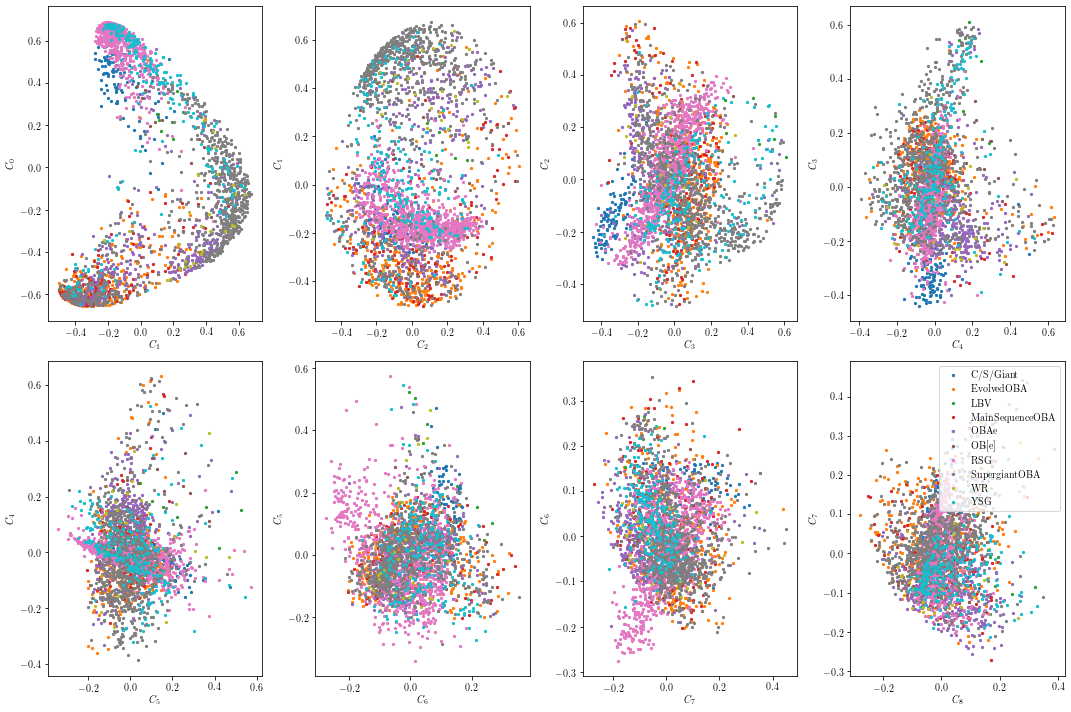

In [9]:
fig, ax = plt.subplots(2,4,figsize=(15,10))
a = ax.flatten()
for i in range(kpca.n_components-1):
    for j,cl in enumerate(np.unique(y)):
        this_class = X_r[y==cl]
        if i == 7:
            lab = cl
        else:
            lab = None
        a[i].scatter(this_class[f'C_{i+1}'],this_class[f'C_{i}'],s=5,label=lab)
    a[i].set(ylabel=f'$C_{i}$',xlabel=f'$C_{i+1}$')
a[7].legend()
plt.tight_layout()

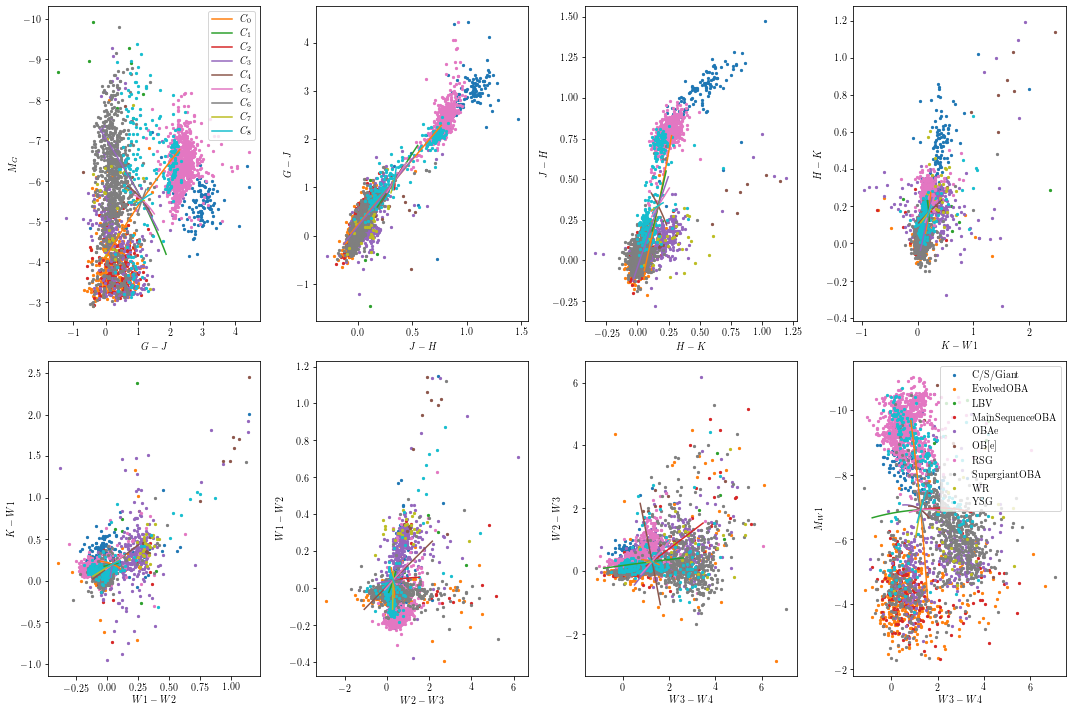

In [10]:
fig, ax = plt.subplots(2,4,figsize=(15,10))
a = ax.flatten()
for i,col in enumerate(X.columns.values[:-1]):
    for j,cl in enumerate(np.unique(y)):
        this_class = X[y==cl]
        if i != 7:
            a[i].scatter(this_class[f'{X.columns.values[i+1]}'],this_class[f'{col}'],s=5)
            a[i].set(ylabel=f'${col}$',xlabel=f'${X.columns.values[i+1]}$')
        else:
            a[i].scatter(this_class[f'{col}'],this_class[f'{X.columns.values[i+1]}'],s=5,label=cl)
            a[i].set(xlabel=f'${col}$',ylabel=f'${X.columns.values[i+1]}$')
        if i in [0,7]:
            a[i].invert_yaxis()
            
xlims = [axis.get_xlim() for axis in a]
ylims = [axis.get_ylim() for axis in a]
        
for i,col in enumerate(X_r.columns):
    X_comp = X_test.iloc[100*i:100*(i+1),:]
    for j,col in enumerate(X.columns.values[:-1]):
        if j == 0:
            a[j].plot(X_comp[f'{X.columns.values[j+1]}'],X_comp[f'{col}'],c=f'C{i+1}',label=f'$C_{i}$')
        elif j == 7:
            a[j].plot(X_comp[f'{col}'],X_comp[f'{X.columns.values[j+1]}'],c=f'C{i+1}')
        else:
            a[j].plot(X_comp[f'{X.columns.values[j+1]}'],X_comp[f'{col}'],c=f'C{i+1}')
a[7].legend()
a[0].legend()

for i in range(len(a)):
    a[i].set_xlim(xlims[i])
    a[i].set_ylim(ylims[i])
    if i in [0,7]:
        a[i].invert_yaxis()

plt.tight_layout()

In [11]:
X_r['Class'] = y
X_r.to_csv('transformed_features.csv',index=False)